# Importing the data

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
!pip install boruta
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

For this project I used the NBA Stats (1947-present) dataset from kaggle. The datasets includes all kind of data but for my purposes I only used the award shares stats, player per game stats, advanced players stats and the team total stats.

In [89]:
shares = pd.read_csv("/content/Player Award Shares.csv")
per_game = pd.read_csv("/content/Player Per Game.csv")
advanced = pd.read_csv("/content/Advanced.csv")
wins = pd.read_csv("/content/Team Summaries.csv")

The goal of our project is to predict the 2025 NBA MVP award winner, which has one of the most exciting races in recent history, with two all time talents going head to head - Nikola Jokić vs Shai Gilgeus-Alexander.

So how exactly is the MVP winner chosen? Well, the NBA MVP award is determined using a Borda count voting system, where higher-ranked votes are weighted more heavily. In this system, a first-place vote carries more value than second or third, emphasizing players who consistently rank near the top across all ballots. Each year, a panel of sports journalists and broadcasters from the U.S. and Canada submit their top five MVP selections. Points are allocated as follows:
1st place – 10 points
2nd place – 7 points
3rd place – 5 points
4th place – 3 points
5th place – 1 point

After all the ballots are submitted, the total points are calculated. The player with the highest point total is awarded the MVP. This voting system was first introduced by the NBA in the 1980–81 season. Before that, the MVP was still voted on by media members, but the voting structure and transparency were less standardized.

Knowing all that information we know that the goal of our project is to predict the NBA award share - how much of the total points has the player obtained. From that, it looks like this would be a classic supervised regression problem. Now that we have some direction, let's look at the data.

# Data Cleaning and Feature Engineering
First of all we have to combine all of our datasets into one dataframe containing only the important information. Also because of the change in the MVP voting system, which we talked about before, we will only use the data from the 1981-1982 upwards (the rules changed in 1980-81 but for this season we have incompleted data). Finally, we will exclude the 2024 season from our data and put it aside as a testing set and also exclude 2025 season as we will predict it at the end.

In [90]:
# Making a dataframe with only the NBA MVP award columns
mvp_shares = shares[shares["award"] == "nba mvp"]

# Combining the per_game stats with the award share value and the boolean value if the player was MVP that year
stats = pd.merge(per_game, mvp_shares[["season", "player", "share", "winner"]], how="left", on=["season", "player"])

# Combining the advanced stats with our new stats dataframe
stats = pd.merge(stats, advanced[["seas_id", "player_id", 'per', 'ts_percent', 'x3p_ar', 'f_tr', 'orb_percent', 'drb_percent', 'trb_percent', 'ast_percent', 'stl_percent', 'blk_percent', 'tov_percent', 'usg_percent', 'ows', 'dws', 'ws', 'ws_48', 'obpm', 'dbpm', 'bpm', 'vorp']], how="left", on=["seas_id", "player_id"])

# Combining the team stats with our new stats dataframe
wins.rename(columns={"abbreviation": "tm"}, inplace=True)
stats = pd.merge(stats, wins[["season", "tm", "w", "l"]], how="left", on=["season", "tm"])

# Taking only the data from 1981-1982 season upwards
stats = stats[stats["season"] >= 1982]

# Derive datasets training, testing and prediction
predict = stats[stats["season"] == 2025]
test = stats[stats["season"] == 2024]
df = stats[stats["season"] < 2024]

df.head(10)

,seas_id,season,player_id,player,birth_year,pos,age,experience,lg,tm,...,ows,dws,ws,ws_48,obpm,dbpm,bpm,vorp,w,l
1403,30458.0,2023,5025.0,A.J. Green,NaN,SG,23.0,1,NBA,MIL,...,0.5,0.3,0.8,0.111,-0.3,-0.6,-0.9,0.1,58.0,24.0
1404,30459.0,2023,5026.0,A.J. Lawson,NaN,SG,22.0,1,NBA,TOT,...,0.1,0.1,0.1,0.063,-1.5,-2.9,-4.4,-0.1,NaN,NaN
1405,30460.0,2023,5026.0,A.J. Lawson,NaN,SG,22.0,1,NBA,MIN,...,0.0,0.0,0.0,0.377,-2.3,7.5,5.2,0.0,42.0,40.0
1406,30461.0,2023,5026.0,A.J. Lawson,NaN,SG,22.0,1,NBA,DAL,...,0.1,0.1,0.1,0.057,-1.5,-3.1,-4.6,-0.1,38.0,44.0
1407,30462.0,2023,5027.0,AJ Griffin,NaN,SF,19.0,1,NBA,ATL,...,1.3,0.9,2.2,0.075,-0.3,-0.5,-0.8,0.4,41.0,41.0
1408,30463.0,2023,4219.0,Aaron Gordon,NaN,PF,27.0,9,NBA,DEN,...,4.6,2.2,6.8,0.158,2.4,-0.3,2.1,2.1,53.0,29.0
1409,30464.0,2023,4582.0,Aaron Holiday,NaN,PG,26.0,5,NBA,ATL,...,0.3,0.6,0.9,0.053,-2.9,0.9,-2.0,0.0,41.0,41.0
1410,30465.0,2023,4805.0,Aaron Nesmith,NaN,SF,23.0,3,NBA,IND,...,0.9,1.1,2.0,0.052,-2.3,-0.7,-3.0,-0.4,35.0,47.0
1411,30466.0,2023,4900.0,Aaron Wiggins,NaN,SG,24.0,2,NBA,OKC,...,1.4,1.2,2.6,0.097,-1.5,-0.5,-2.1,0.0,40.0,42.0
1412,30467.0,2023,4688.0,Admiral Schofield,NaN,PF,25.0,3,NBA,ORL,...,0.5,0.3,0.8,0.089,-2.2,-0.7,-2.9,-0.1,34.0,48.0


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22437 entries, 1403 to 23839
Data columns (total 59 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   seas_id        22421 non-null  float64
 1   season         22437 non-null  int64  
 2   player_id      22421 non-null  float64
 3   player         22437 non-null  object 
 4   birth_year     502 non-null    float64
 5   pos            22437 non-null  object 
 6   age            22437 non-null  float64
 7   experience     22437 non-null  int64  
 8   lg             22437 non-null  object 
 9   tm             22437 non-null  object 
 10  g              22437 non-null  int64  
 11  gs             22437 non-null  float64
 12  mp_per_game    22437 non-null  float64
 13  fg_per_game    22437 non-null  float64
 14  fga_per_game   22437 non-null  float64
 15  fg_percent     22318 non-null  float64
 16  x3p_per_game   22437 non-null  float64
 17  x3pa_per_game  22437 non-null  float64
 18  x3p_perc

### Multiple Rows for one player
So the first problem we encounter in our data is that because of trades happening we have more than 1 row for player in a season - for the teams he played for and total stats for the season. The example here is AJ Johnson, who has 3 rows, 1 for MIL, 1 for WAS and finally 1 for the TOT. To fix that we will take player's stats from a whole season, assign him to the latest team they played for and then remove other rows.

In [92]:
# Grouping the players by the season
grouped_df = df.groupby(["season", "player_id"])
grouped_test = test.groupby(["season", "player_id"])
grouped_predict = predict.groupby(["season", "player_id"])

# Function to remove the unecessary rows for the player in the season
def filter_players(group):
    if "TOT" in group["tm"].values:

        # Get the TOT row and copy it to avoid modifying original
        tot_row = group[group["tm"] == "TOT"].iloc[0:1].copy()

        # Set the team to be the last team the player played for
        tot_row.loc[:, "tm"] = group.iloc[-1]["tm"]

        # Set the wins and loses to be as the last team the player played for
        tot_row.loc[:, "w"] = group.iloc[-1]["w"]
        tot_row.loc[:, "l"] = group.iloc[-1]["l"]

        return tot_row

    # Otherwise return the last row
    return group.iloc[-1:].copy()

df = grouped_df.apply(filter_players).reset_index(drop=True)
test = grouped_test.apply(filter_players).reset_index(drop=True)
predict = grouped_predict.apply(filter_players).reset_index(drop=True)

<ipython-input-92-114642552a91>:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = grouped_df.apply(filter_players).reset_index(drop=True)
<ipython-input-92-114642552a91>:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test = grouped_test.apply(filter_players).reset_index(drop=True)
<ipython-input-92-114642552a91>:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This be

In [93]:
df.query("player == 'AJ Johnson'")

,seas_id,season,player_id,player,birth_year,pos,age,experience,lg,tm,...,ows,dws,ws,ws_48,obpm,dbpm,bpm,vorp,w,l


In [94]:
player_rows_stats = df.groupby(["season", "player_id"]).size()
print(player_rows_stats.max())

1


As we can see above the problem has been resolved and now we have only one row for a one player in a season.

### Empty Values
The other problem we encountered is many columns contain empty values, including the one we want to predict - "share". We will fill those missing values with 0 in case for stats and share, false in case for "birth_year" we will just drop the column because it's not relevant since we already have age values.

In [95]:
df.isna().sum()

,0
seas_id,0
season,0
player_id,0
player,0
birth_year,17821
pos,0
age,0
experience,0
lg,0
tm,0


In [96]:
# Define the columns to fill the empty values with 0 for different dataframes
fill_0 = ['g', 'gs', 'mp_per_game', 'fg_per_game', 'fga_per_game', 'fg_percent', 'x3p_per_game', 'x3pa_per_game', 'x3p_percent', 'x2p_per_game', 'x2pa_per_game', 'x2p_percent', 'e_fg_percent', 'ft_per_game', 'fta_per_game', 'ft_percent', 'orb_per_game', 'drb_per_game', 'trb_per_game', 'ast_per_game', 'stl_per_game', 'blk_per_game', 'tov_per_game', 'pf_per_game', 'pts_per_game', 'share', 'per', 'ts_percent', 'x3p_ar', 'f_tr', 'orb_percent', 'drb_percent', 'trb_percent', 'ast_percent', 'stl_percent', 'blk_percent', 'tov_percent', 'usg_percent', 'ows', 'dws', 'ws', 'ws_48', 'obpm', 'dbpm', 'bpm', 'vorp']
fill_0_mvp = fill_0.copy()
fill_0_mvp.remove("share")

df[fill_0] = df[fill_0].fillna(0)
test[fill_0] = test[fill_0].fillna(0)
predict[fill_0_mvp] = predict[fill_0_mvp].fillna(0)

df["winner"] = df["winner"].fillna(False)
test["winner"] = test["winner"].fillna(False)

df.drop("birth_year", axis=1, inplace=True)
test.drop("birth_year", axis=1, inplace=True)
predict.drop("birth_year", axis=1, inplace=True)

<ipython-input-96-e1a7ea871907>:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["winner"] = df["winner"].fillna(False)
<ipython-input-96-e1a7ea871907>:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test["winner"] = test["winner"].fillna(False)


In [97]:
df.isna().sum()

,0
seas_id,0
season,0
player_id,0
player,0
pos,0
age,0
experience,0
lg,0
tm,0
g,0


### Repetetive Stats
Now we will move onto feature engineering - transforming raw data into informative features that capture underlying patterns and improve model performance, which is a crucial step in any Machine Learning project.

In feature engineering we don't just add new features, we also remove values if they are not useful. In our data sets we have many features which can be made out of two other features - offensive + defensive rebounds per game  = total rebounds per game. As we can see on the graph below those the original stat and the derived stat have almost perfect correlation of 1. Thus, we will remove the original stat and keep the features which we can derive it from.

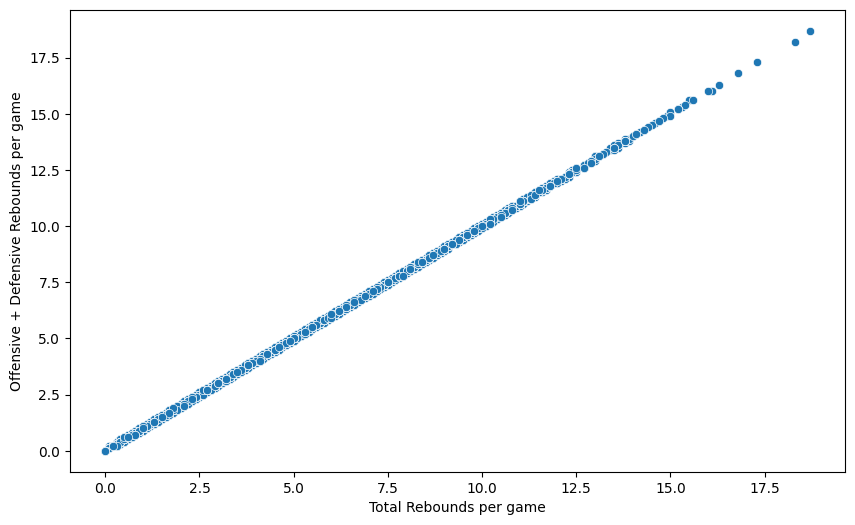

np.float64(0.9998186193958029)

In [98]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df["trb_per_game"], y=df["orb_per_game"] + df["drb_per_game"])
plt.xlabel("Total Rebounds per game")
plt.ylabel("Offensive + Defensive Rebounds per game")
plt.show()

df["trb_per_game"].corr(df["orb_per_game"] + df["drb_per_game"])

In [99]:
derivable_stats = ['fg_per_game', 'x3p_per_game', 'x2p_per_game', 'e_fg_percent', 'ft_per_game', 'orb_per_game', 'drb_per_game', "x3p_ar", "f_tr", 'trb_percent', "ws", "ws_48", "bpm"]

df.drop(derivable_stats, axis=1, inplace=True)
test.drop(derivable_stats, axis=1, inplace=True)
predict.drop(derivable_stats, axis=1, inplace=True)

Same can be said with the win and loses column, that's why we will will add a new column for win percentage and drop the original columns.

In [100]:
df["win_percent"] = round(df["w"] / (df["w"] + df["l"]), 3)
test["win_percent"] = round(test["w"] / (test["w"] + test["l"]), 3)
predict["win_percent"] = round(predict["w"] / (predict["w"] + predict["l"]), 3)

df.drop(["w", "l"], axis=1, inplace=True)
test.drop(["w", "l"], axis=1, inplace=True)
predict.drop(["w", "l"], axis=1, inplace=True)

### Imbalanced Data
Another major problem we have in our dataset is that our data is very imbalanced.

An imbalanced dataset means that the observations in the target variable are not evenly distributed—one class is much more prevalent than the other. In this case, the bulk of the data falls into the majority class (players who did not receive MVP votes), while only a small fraction represents the minority class (players who received MVP votes).

The key issue with imbalanced data is achieving accurate predictions for both classes. For example we would like to predict whether a fruit is an apple or an orange. If our dataset consists of 990 apples and 10 oranges, then a very simple model which predicts every fruit is an apple would get a accuracy of 99%, which looks very impressive, it fails at the core objective: classifying fruits.

Similarly, if our NBA MVP model always predicts a vote share of zero for every player, it might score high in overall accuracy but would be ineffective at identifying the true MVP candidates. Therefore, balancing the dataset is essential so that the model can learn the real relationships between players' statistics and their MVP vote shares.

One effective strategy for balancing an imbalanced dataset is to first reduce the size of the majority class through undersampling, and then apply SMOTE (Synthetic Minority Over-sampling Technique) to create synthetic samples for the minority class. This approach helps ensure that the model has enough data from both classes to learn meaningful patterns.

Let's take a look at our classes.


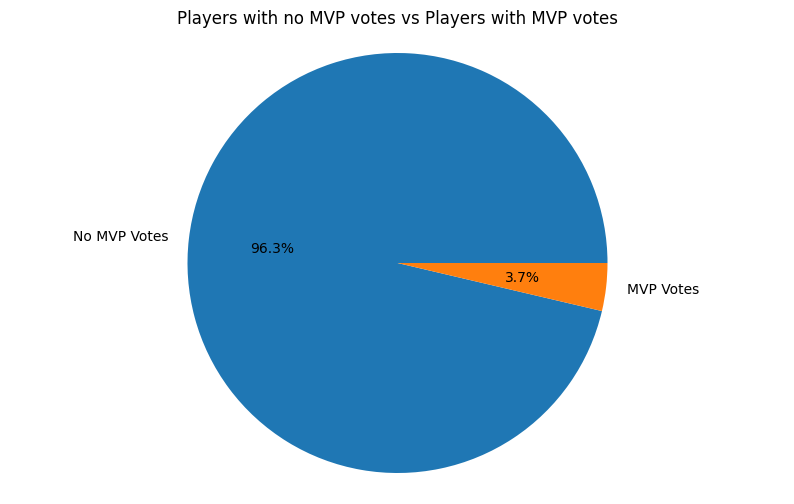

In [101]:
size_before = len(df)

# Getting the size of the classes
classes = df["share"] > 0

# Splitting the data into the information dataframe and data dataframe
info_df = df[["player", "player_id", "seas_id", "pos", "lg", "tm"]]
data_df = df.drop(["player", "player_id", "seas_id", "pos", "lg", "tm"], axis = 1)

# Calculate counts for each class
vote_yes = (df["share"] > 0).sum()
vote_no = (df["share"] <= 0).sum()

plt.figure(figsize=(10,6))
plt.pie([vote_no, vote_yes], labels=["No MVP Votes", "MVP Votes"], autopct='%1.1f%%')
plt.axis("equal")
plt.title("Players with no MVP votes vs Players with MVP votes")
plt.show()

### Undersampling
We will start of with undersampling our majority class. One of the most common methods for it is random undersampling, where we remove random subset from our majority class. Although it can be effective, the major drawback is that we could remove players whose stats would be meaningful to the model while keeping players whose stats are irrelevant.

That's why we will take a different approach - removing players who have very low chance of receiving points (players who didn't play many games, didn't start games, didn't play many minutes, score few points etc).

We will start of by removing players who didn't start many games. Let's take a look at the distribution of games started of players who had NBA MVP votes versus no MVP Votes.

In [102]:
# Defining the two classes - players who had MVP votes and players who didn't
mvp_shares = df[df["share"] > 0]
no_mvp_shares = df[df["share"] == 0]

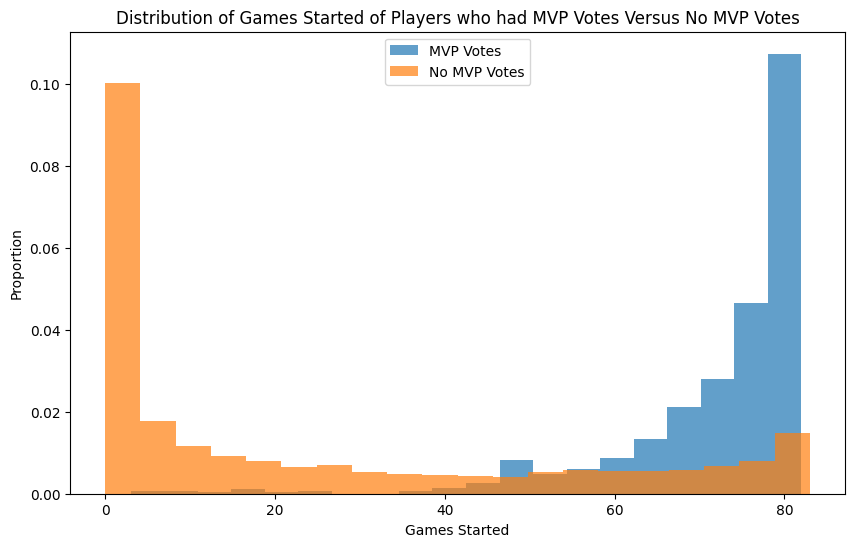

In [103]:
plt.figure(figsize=(10,6))
plt.hist(mvp_shares["gs"], bins = 20, alpha = 0.7, density=True, label = "MVP Votes")
plt.hist(no_mvp_shares["gs"], bins = 20, alpha = 0.7, density=True, label = "No MVP Votes")
plt.ylabel("Proportion")
plt.xlabel("Games Started")
plt.title("Distribution of Games Started of Players who had MVP Votes Versus No MVP Votes")
plt.legend()
plt.show()

In [104]:
mvp_shares[mvp_shares["winner"] == True][["season", "player", "gs"]].sort_values("gs").head(5)

,season,player,gs
6297,1999,Karl Malone,49.0
12187,2012,LeBron James,62.0
16158,2020,Giannis Antetokounmpo,63.0
17853,2023,Joel Embiid,66.0
7366,2001,Allen Iverson,71.0


To win the MVP award you must start a lot of matches (only the best players start the game). The fewest amunt of games started to get an MVP award was 49 by Karl Malone in a lockout shortened 1998-1999 season. So by looking at the distribution it would be safe to assume that to win the MVP you must start atleast 25 games. Let's look at some players who started less than that but still received MVP votes.

In [105]:
mvp_shares[mvp_shares["gs"] <= 25]

,seas_id,season,player_id,player,pos,age,experience,lg,tm,g,...,stl_percent,blk_percent,tov_percent,usg_percent,ows,dws,obpm,dbpm,vorp,win_percent
156,8951.0,1982,1823.0,Michael Cooper,SG,25.0,4,NBA,LAL,76,...,2.5,1.5,15.6,17.5,2.4,2.6,-0.3,1.2,1.6,0.695
3022,12499.0,1991,1938.0,Kevin McHale,PF,33.0,11,NBA,BOS,68,...,0.6,4.0,11.9,23.9,5.3,2.6,2.6,0.5,2.7,0.683
3485,12817.0,1992,2236.0,Detlef Schrempf,PF,29.0,7,NBA,IND,80,...,1.2,0.8,14.6,21.1,7.1,2.8,3.0,0.1,3.3,0.488
4599,14392.0,1995,2193.0,Michael Jordan,SG,31.0,10,NBA,CHI,17,...,2.3,1.5,7.0,33.2,1.2,1.1,3.6,0.6,1.1,0.573
4963,14887.0,1996,1878.0,Magic Johnson,PF,36.0,13,NBA,LAL,32,...,1.4,1.0,21.2,22.7,2.6,1.1,4.7,0.5,1.8,0.646
6495,16338.0,1999,2846.0,Darrell Armstrong,PG,30.0,5,NBA,ORL,50,...,3.9,0.2,20.8,22.9,3.8,2.7,4.2,2.4,3.3,0.660
6549,16589.0,1999,2950.0,Rasheed Wallace,PF,24.0,4,NBA,POR,49,...,1.8,2.9,12.6,20.5,2.6,2.4,0.2,1.8,1.4,0.700
10474,21344.0,2008,3401.0,Manu Ginóbili,SG,30.0,6,NBA,SAS,74,...,2.6,1.1,14.5,28.7,6.6,4.5,5.6,2.7,6.0,0.683
11306,22516.0,2010,3401.0,Manu Ginóbili,SG,32.0,8,NBA,SAS,75,...,2.5,0.8,12.7,25.8,6.5,3.2,5.1,1.6,4.7,0.610
16580,29118.0,2021,3812.0,Derrick Rose,PG,32.0,12,NBA,NYK,50,...,1.9,1.4,10.5,25.8,1.6,1.6,1.6,0.3,1.3,0.569


So the players which started maximum of 25 games are mostly 6th men (players who came of the bench but still player crucial role in the team).

In [106]:
len(df[df["gs"] <= 25]) / size_before

0.620152487521255

In [107]:
len(df[df["gs"] > 25])

6925

By filtering out players who played in fewer than 25 games, we reduced our dataset to 7,108 players—approximately 40% of the original sample. Notably, this filter removed only 10 players who received MVP votes, while excluding 11695 players who hadn't played enough games to be realistically considered for the MVP award. Although this strategy refines our analysis by focusing on players with a meaningful amount of participation, the dataset remains highly imbalanced in terms of MVP representation.

In [108]:
# Applying the filter to our data
df = df[df["gs"] > 25].reset_index(drop=True)
test = test[test["gs"] > 25].reset_index(drop=True)
predict = predict[predict["gs"] > 25].reset_index(drop=True)

Now we will look at the distribution of minutes per game of players who had NBA MVP votes versus no MVP Votes.

In [109]:
# Redefining the two classes - players who had MVP votes and players who didn't
mvp_shares = df[df["share"] > 0]
no_mvp_shares = df[df["share"] == 0]

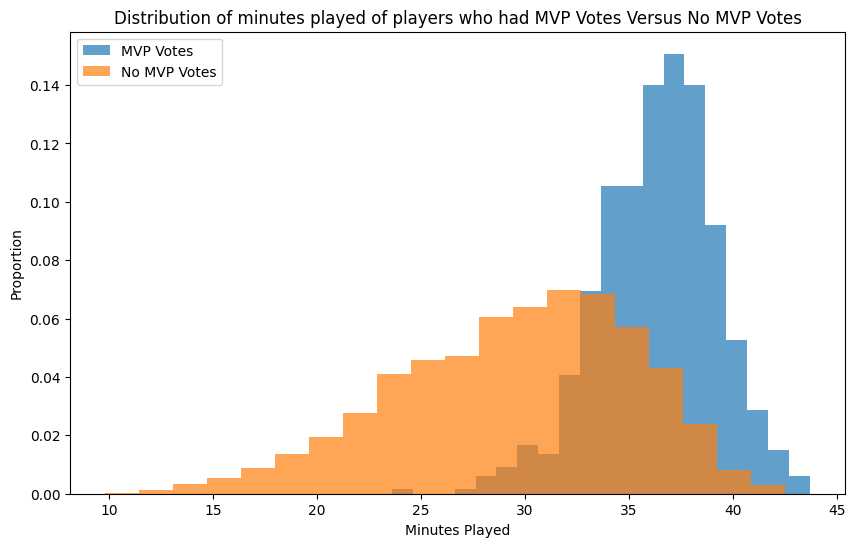

The cutoff value is equal to: 27.952176791033786 minutes per game


In [110]:
plt.figure(figsize=(10,6))
plt.hist(mvp_shares["mp_per_game"], bins = 20, alpha = 0.7, density=True, label = "MVP Votes")
plt.hist(no_mvp_shares["mp_per_game"], bins = 20, alpha = 0.7, density=True, label = "No MVP Votes")
plt.ylabel("Proportion")
plt.xlabel("Minutes Played")
plt.title("Distribution of minutes played of players who had MVP Votes Versus No MVP Votes")
plt.legend()
plt.show()

cutoff_mp = mvp_shares["mp_per_game"].mean() - 3 * mvp_shares["mp_per_game"].std()
print(f"The cutoff value is equal to: {cutoff_mp} minutes per game")

To win the NBA award it is logical that you should play a significant amount of minutes on the court. Our next step is to remove players that didn't have a lot of playing time.

For our cutoff value I will use the third standard deviation from the mean minutes played per game by players who received MVP votes. This ended up being 27.91 minutes per game.

In [111]:
mvp_shares[mvp_shares["mp_per_game"] <= cutoff_mp]

,seas_id,season,player_id,player,pos,age,experience,lg,tm,g,...,stl_percent,blk_percent,tov_percent,usg_percent,ows,dws,obpm,dbpm,vorp,win_percent
241,9090.0,1983,1978.0,Alton Lister,PF,24.0,2,NBA,MIL,80,...,1.3,5.2,23.1,17.7,-0.2,3.9,-2.9,2.4,0.7,0.622
2651,16240.0,1999,2897.0,Arvydas Sabonis,C,34.0,4,NBA,POR,50,...,1.4,3.5,13.3,21.7,3.0,2.9,1.8,2.4,2.1,0.700


So the only players here are Alton Lister and Arvydas Sabonis. Both of these players are outliers who received some votes, probably due to voter's bias.

Now we will take a look at the distribution of points per game of players who had NBA MVP votes versus no MVP Votes.

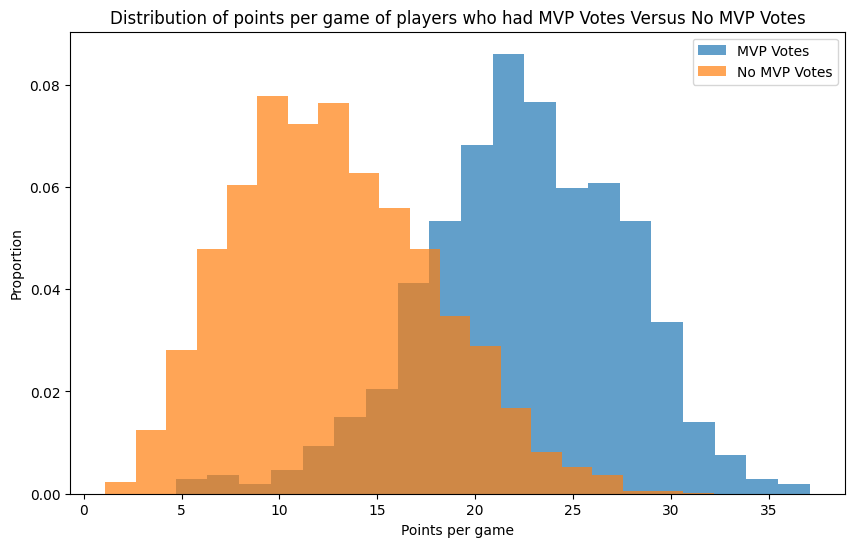

The cutoff value is equal to: 7.127414038867647 points per game


In [112]:
plt.figure(figsize=(10,6))
plt.hist(mvp_shares["pts_per_game"], bins = 20, alpha = 0.7, density=True, label = "MVP Votes")
plt.hist(no_mvp_shares["pts_per_game"], bins = 20, alpha = 0.7, density=True, label = "No MVP Votes")
plt.ylabel("Proportion")
plt.xlabel("Points per game")
plt.title("Distribution of points per game of players who had MVP Votes Versus No MVP Votes")
plt.legend()
plt.show()

cutoff_pts = mvp_shares["pts_per_game"].mean() - 3 * mvp_shares["pts_per_game"].std()
print(f"The cutoff value is equal to: {cutoff_pts} points per game")

As we know the team that scores more points than the opposing team wins the basketball game. So intuitively the best players should score the most points.

For our cutoff value I will again use the third standard deviation from the mean points per game by players who received MVP votes. This ended up being 7.14 points per game.

In [113]:
mvp_shares[mvp_shares["pts_per_game"] <= cutoff_pts]

,seas_id,season,player_id,player,pos,age,experience,lg,tm,g,...,stl_percent,blk_percent,tov_percent,usg_percent,ows,dws,obpm,dbpm,vorp,win_percent
1006,11635.0,1989,2081.0,Mark Eaton,C,32.0,7,NBA,UTA,82,...,0.7,6.5,22.3,9.2,0.0,6.5,-2.5,3.1,1.9,0.622
1761,13724.0,1994,2301.0,Dennis Rodman,PF,32.0,8,NBA,SAS,79,...,0.9,0.7,29.1,7.1,3.3,5.4,0.7,0.3,2.3,0.671
1904,14199.0,1995,2301.0,Dennis Rodman,PF,33.0,9,NBA,SAS,49,...,1.0,1.0,25.3,10.9,2.6,3.2,1.4,0.4,1.5,0.756
2065,14682.0,1996,2301.0,Dennis Rodman,PF,34.0,10,NBA,CHI,64,...,0.9,1.0,28.2,10.3,1.7,4.6,-0.3,0.3,1.1,0.878
3265,18288.0,2003,2971.0,Ben Wallace,C,28.0,7,NBA,DET,73,...,2.0,5.9,14.5,10.2,2.7,7.9,0.4,3.5,4.3,0.610


As we can see the players who scored less or equal to our cutoff value where defensive specialists - Dennis Rodman, Mark Eaton and Ben Wallace (all combining for 8 Defensive Player of the Year awards). Although these players created massive impact on the defensive end, the MVP award tends to favour the offensive players more, making them outliers.

Now finally we can apply those filters to our data and reduce the size of it.

In [114]:
# Applying the rest of the filters to our data
df = df[(df["pts_per_game"] > cutoff_pts) & (df["mp_per_game"] > cutoff_mp)].reset_index(drop = True)
test = test[(test["pts_per_game"] > cutoff_pts) & (test["mp_per_game"] > cutoff_mp)].reset_index(drop = True)
predict = predict[(predict["pts_per_game"] > cutoff_pts) & (predict["mp_per_game"] > cutoff_mp)].reset_index(drop = True)

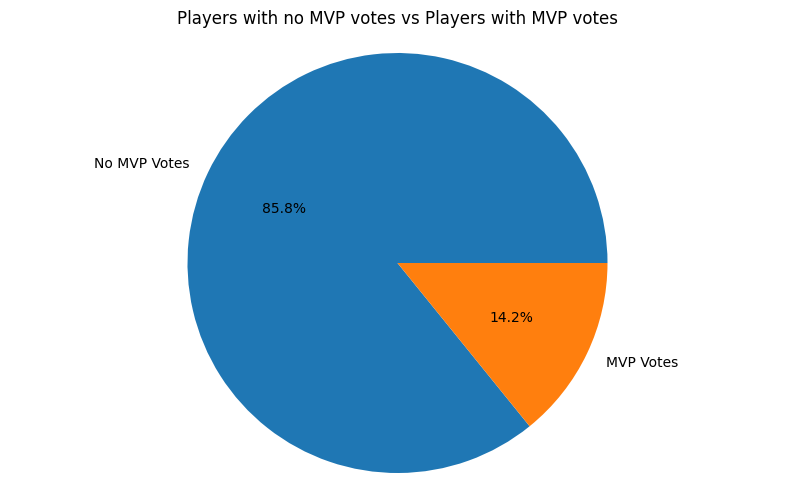

In [115]:
# Calculate counts for each class
vote_yes = (df["share"] > 0).sum()
vote_no = (df["share"] <= 0).sum()

plt.figure(figsize=(10,6))
plt.pie([vote_no, vote_yes], labels=["No MVP Votes", "MVP Votes"], autopct='%1.1f%%')
plt.axis("equal")
plt.title("Players with no MVP votes vs Players with MVP votes")
plt.show()

We reduced our dataset by 13994 (!), which is a lot, however it is still pretty imbalanced as only 14.2% of the players in our dataset have received MVP votes. To fix this problem we can use SMOTE to oversample over minority class. SMOTE stands for Synthetic Minority Oversampling Technique and it does exactly what the name implies - it creates synthetic samples of the minority class. We will do that right now.

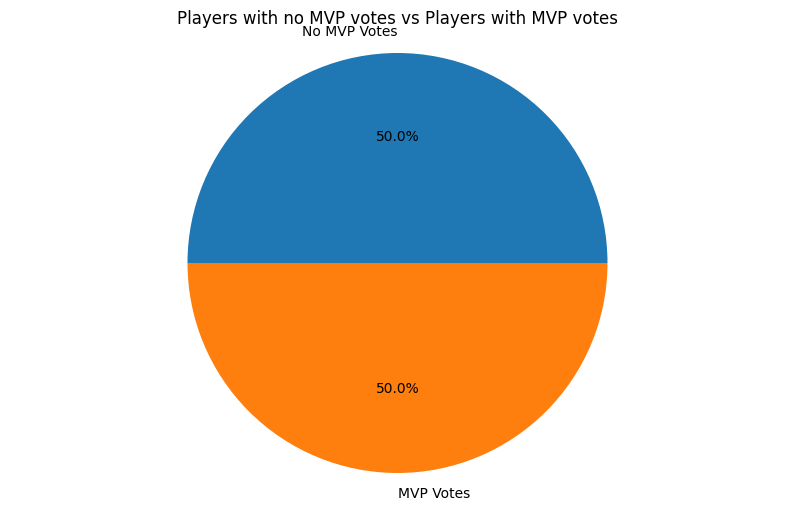

In [116]:
# Calculate the sizes of the classes
classes = df["share"] > 0

# Define dataset with only the features
data_df = df.drop(["player", "player_id", "seas_id", "pos", "lg", "tm", "winner"], axis = 1)

# Define the length of the dataset before SMOTE
unsmote_len = len(data_df)

# Generate the synthetic data to balance the classes
smote = SMOTE(sampling_strategy = 1, random_state=0)
data_df, classes = smote.fit_resample(data_df, classes)

# Calculate counts for each class
vote_yes = (data_df["share"] > 0).sum()
vote_no = (data_df["share"] <= 0).sum()

plt.figure(figsize=(10,6))
plt.pie([vote_no, vote_yes], labels=["No MVP Votes", "MVP Votes"], autopct='%1.1f%%')
plt.axis("equal")
plt.title("Players with no MVP votes vs Players with MVP votes")
plt.show()

We've oversampled our minority sample, but there's an issue we need to address. Our synthetic data doesn't correspond to any actual player or season, which complicates determining the true MVP. With our synthetic data potentially outperforming the actual MVP of a given year, it's crucial to differentiate between the two. Since the SMOTE function appends synthetic data to the end of our dataset, we can use this fact to label the data points accordingly as either synthetic or authentic.

In [117]:
data_df["is_smote"] = data_df.index >= unsmote_len
labeled_df = data_df.merge(df, how = "left")

Finally, after all that work we have a balanced dataset. However, we are far from done. Our next step will be feature selection.

# Feature Selection
One of the most important things when feeding the data into the models is to make sure we are not putting in just noise, but actual meaningful data. Not all stats are equally valued when predicting the MVP - points per game tend to be more valued than assists per game in an MVP race.

It's a common misconception that accumulating more data will inherently boost model performance. However, this is only true if the additional data is relevant and meaningful to the task at hand. For example, tracking the amount of water consumed per game might not enhance your model's predictions. Instead, it's essential to focus on identifying and retaining only those features that truly contribute to the outcome. This targeted approach is known as feature selection.

While many approaches exist for this task, I'm opting for the Boruta method in this project. This statistically driven technique identifies which features are truly significant, ensuring that only the most impactful attributes are considered during feature selection.

In [118]:
# from boruta import BorutaPy
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import RandomForestClassifier
# import numpy as np
#
# rfr = RandomForestRegressor(max_depth = 5, n_jobs=-1, n_estimators=500, oob_score=True, random_state=0)
# trans = BorutaPy(rfr, n_estimators = "auto", random_state=42, verbose=2)
# selector = trans.fit(data_df.drop(["share", "season", "is_smote"],axis= 1).to_numpy(),
#                      data_df["share"].to_numpy())

In [119]:
# columns = data_df.drop(["share", "season", "is_smote"],axis= 1).columns[selector.ranking_ <= 2]

(!) To speed up the process of running this notebook use these columns instead of using the Boruta Method.

In [120]:
columns = [
    'age', 'experience', 'gs', 'mp_per_game', 'fga_per_game', 'fg_percent',
    'x3pa_per_game', 'x3p_percent', 'x2pa_per_game', 'x2p_percent',
    'fta_per_game', 'ft_percent', 'trb_per_game', 'ast_per_game',
    'stl_per_game', 'tov_per_game', 'pf_per_game', 'pts_per_game', 'per',
    'ts_percent', 'orb_percent', 'drb_percent', 'ast_percent',
    'stl_percent', 'blk_percent', 'tov_percent', 'usg_percent', 'ows',
    'dws', 'obpm', 'dbpm', 'vorp', 'win_percent'
]

From the Boruta method we know that these features are the most important in predicting the NBA MVP. But let's look at the columns that were excluded from this list.

In [121]:
set(df.columns) - set(columns)

{'blk_per_game',
 'g',
 'lg',
 'player',
 'player_id',
 'pos',
 'seas_id',
 'season',
 'share',
 'tm',
 'winner'}

As we can see the columns that were removed were mostly the informational columns like player, position, season/season id etc. But from the actual statistic it removed games played and blocks per game. Both of them make sense because although you should play most of the games to be considered for the MVP, the total number of them doesn't matter. As for the blocks, they are more considered in the Defensive Player of the Year award, with the MVP tending to be more offense dominant.

Having our features, we can move onto the next step, which is Data Preprocessing.

### Data Preprocessing
Last thing before we feed our data into the models is to split it into the training and test datasets. Also we need to apply the same filters as before to our test set.

In [122]:
# Shuffling the data
model_df = labeled_df.sample(frac=1).reset_index(drop = True)

# Train Data
train_info = model_df[['seas_id', "season", 'player_id', "player", "pos", "lg", "tm", "share",  "winner", "is_smote"]]
train_x = model_df[columns]
train_y = model_df[["share"]]

# Test Data
test_info = test[['seas_id', "season", 'player_id', "player", "pos", "lg", "tm", "share",  "winner"]]
test_x = test[columns]
test_y = test[["share"]]

### Random Forest Regressor
A popular method for creating good regression models is by using Random Forest Models.
Random Forest Models are a very popular method for making good regression models.

However, they can be give biased results if the data isn't balanced. That's why we had to balance our data before training our models.

In [123]:
from sklearn.ensemble import RandomForestRegressor

# Defining the validation scores
validation_scores = {"season" : [], "mae" : [], "was_mvp" : [], "was_top_two" : [], "was_top_three":[], "info" : []}

# Looping through the seasons
seasons = train_info.season.unique()
for season in seasons:
  print("\n")
  print(f"Season: {season}")

# Splitting the data into training and validation sets
  train_fold = train_x[train_info["season"] != season]
  train_tar_fold= train_y[train_info["season"] != season]
  val_fold = train_x[(train_info["season"] == season) & (~train_info["is_smote"])]
  val_tar_fold = train_y[(train_info["season"] == season) & (~train_info["is_smote"])]
  val_info = train_info[(train_info["season"] == season) & (~train_info["is_smote"])]

# Fitting the model
  regr = RandomForestRegressor(max_depth = 7, random_state=0)
  regr.fit(train_fold.to_numpy(), train_tar_fold.to_numpy()[:,0])

# Making predictions
  val_pred = regr.predict(val_fold)
  mae = np.mean(np.absolute(val_pred - val_tar_fold.to_numpy()[:,0]))
  print(f"MAE: {mae}")

    # Get top 2 and top 3 predicted players by sorting prediction values
  top_two = val_info.iloc[np.argsort(val_pred)[-2:]]
  was_top_two = sum(top_two["winner"]) > 0
  top_three = val_info.iloc[np.argsort(val_pred)[-3:]]
  was_top_three = sum(top_three["winner"]) > 0
  print("Predicted top three players in MVP voting with their actual award_share:")
  print(top_three.iloc[::-1])

# Get details about the player with highest predicted value
  mostVotes = np.argmax(val_pred)
  score = np.amax(val_pred)
  winner = val_info.iloc[[mostVotes]]["winner"].values[0]
  player = val_info.iloc[[mostVotes]]["player"].values[0]
  print(f"Predicted MVP: {player}")
  print(f"Predicted Win Share: {score}")
  print(f"Was MVP correct: {winner}")

# Output results
  validation_scores["season"].append(season)
  validation_scores["mae"].append(mae)
  validation_scores["was_mvp"].append(winner)
  validation_scores["was_top_two"].append(was_top_two)
  validation_scores["was_top_three"].append(was_top_three)
  validation_scores["info"].append(val_info.iloc[[mostVotes]])



Season: 2005


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.02160031288574491
Predicted top three players in MVP voting with their actual award_share:
      seas_id  season  player_id            player pos   lg   tm  share  \
2018  19832.0    2005     3028.0        Steve Nash  PG  NBA  PHO  0.839   
4321  19815.0    2005     2751.0  Shaquille O'Neal   C  NBA  MIA  0.813   
2742  19632.0    2005     2936.0     Kevin Garnett  PF  NBA  MIN  0.012   

     winner  is_smote  
2018   True     False  
4321  False     False  
2742  False     False  
Predicted MVP: Steve Nash
Predicted Win Share: 0.6425527790974754
Was MVP correct: True


Season: 2004


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.016661944425216475
Predicted top three players in MVP voting with their actual award_share:
      seas_id  season  player_id            player pos   lg   tm  share  \
1454  19036.0    2004     2936.0     Kevin Garnett  PF  NBA  MIN  0.991   
6828  19255.0    2004     3092.0        Tim Duncan  PF  NBA  SAS  0.582   
4194  19227.0    2004     2751.0  Shaquille O'Neal   C  NBA  LAL  0.145   

     winner  is_smote  
1454   True     False  
6828  False     False  
4194  False     False  
Predicted MVP: Kevin Garnett
Predicted Win Share: 0.6820747943746036
Was MVP correct: True


Season: 1991


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.010850383434342695
Predicted top three players in MVP voting with their actual award_share:
      seas_id  season  player_id          player pos   lg   tm  share winner  \
294   12543.0    1991     2193.0  Michael Jordan  SG  NBA  CHI  0.928   True   
2853  12359.0    1991     2494.0  David Robinson   C  NBA  SAS  0.496  False   
1666  12522.0    1991     1878.0   Magic Johnson  PG  NBA  LAL  0.518  False   

      is_smote  
294      False  
2853     False  
1666     False  
Predicted MVP: Michael Jordan
Predicted Win Share: 0.9279936009839972
Was MVP correct: True


Season: 1990


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.016048732502788376
Predicted top three players in MVP voting with their actual award_share:
      seas_id  season  player_id           player pos   lg   tm  share winner  \
6805  12055.0    1990     1878.0    Magic Johnson  PG  NBA  LAL  0.691   True   
6127  12079.0    1990     2193.0   Michael Jordan  SG  NBA  CHI  0.613  False   
6838  11855.0    1990     2162.0  Charles Barkley  SF  NBA  PHI  0.667  False   

      is_smote  
6805     False  
6127     False  
6838     False  
Predicted MVP: Magic Johnson
Predicted Win Share: 0.7606138085267
Was MVP correct: True


Season: 2000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.010674427059217765
Predicted top three players in MVP voting with their actual award_share:
      seas_id  season  player_id            player pos   lg   tm  share  \
5538  17142.0    2000     2751.0  Shaquille O'Neal   C  NBA  LAL  0.998   
3447  16985.0    2000     2252.0       Karl Malone  PF  NBA  UTA  0.258   
1714  17164.0    2000     3092.0        Tim Duncan  PF  NBA  SAS  0.205   

     winner  is_smote  
5538   True     False  
3447  False     False  
1714  False     False  
Predicted MVP: Shaquille O'Neal
Predicted Win Share: 0.9428114467901544
Was MVP correct: True


Season: 2010


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.014212739457360228
Predicted top three players in MVP voting with their actual award_share:
      seas_id  season  player_id         player pos   lg   tm  share winner  \
6225  22499.0    2010     3462.0   LeBron James  SF  NBA  CLE  0.980   True   
3909  22474.0    2010     3770.0   Kevin Durant  SF  NBA  OKC  0.495  False   
6485  22328.0    2010     3520.0  Dwight Howard   C  NBA  ORL  0.389  False   

      is_smote  
6225     False  
3909     False  
6485     False  
Predicted MVP: LeBron James
Predicted Win Share: 0.9382640364417137
Was MVP correct: True


Season: 1983


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.018459765228104285
Predicted top three players in MVP voting with their actual award_share:
      seas_id  season  player_id         player pos   lg   tm  share winner  \
3817   9355.0    1983     1605.0   Moses Malone   C  NBA  PHI  0.960   True   
7340   9321.0    1983     1878.0  Magic Johnson  SG  NBA  LAL  0.406  False   
164    9301.0    1983     1875.0     Larry Bird  PF  NBA  BOS  0.485  False   

      is_smote  
3817     False  
7340     False  
164      False  
Predicted MVP: Moses Malone
Predicted Win Share: 0.43333034510953533
Was MVP correct: True


Season: 1999


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.022555843358705082
Predicted top three players in MVP voting with their actual award_share:
      seas_id  season  player_id            player pos   lg   tm  share  \
6816  16488.0    1999     2252.0       Karl Malone  PF  NBA  UTA  0.701   
2257  16638.0    1999     2751.0  Shaquille O'Neal   C  NBA  LAL  0.075   
5022  16216.0    1999     2967.0     Allen Iverson  SG  NBA  PHI  0.270   

     winner  is_smote  
6816   True     False  
2257  False     False  
5022  False     False  
Predicted MVP: Karl Malone
Predicted Win Share: 0.4477373028509744
Was MVP correct: True


Season: 1998


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.014995240916957156
Predicted top three players in MVP voting with their actual award_share:
      seas_id  season  player_id            player pos   lg   tm  share  \
741   15974.0    1998     2252.0       Karl Malone  PF  NBA  UTA  0.726   
3512  16041.0    1998     2193.0    Michael Jordan  SG  NBA  CHI  0.934   
488   16118.0    1998     2751.0  Shaquille O'Neal   C  NBA  LAL  0.268   

     winner  is_smote  
741   False     False  
3512   True     False  
488   False     False  
Predicted MVP: Karl Malone
Predicted Win Share: 0.5271860102878708
Was MVP correct: False


Season: 1982


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.02230683931699413
Predicted top three players in MVP voting with their actual award_share:
      seas_id  season  player_id         player pos   lg   tm  share winner  \
7125   8939.0    1982     1878.0  Magic Johnson  SG  NBA  LAL  0.097  False   
3990   8896.0    1982     1381.0  Julius Erving  SF  NBA  PHI  0.294  False   
1709   8922.0    1982     1875.0     Larry Bird  PF  NBA  BOS  0.588  False   

      is_smote  
7125     False  
3990     False  
1709     False  
Predicted MVP: Magic Johnson
Predicted Win Share: 0.27361054871727053
Was MVP correct: False


Season: 1997


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.011557286150421217
Predicted top three players in MVP voting with their actual award_share:
      seas_id  season  player_id          player pos   lg   tm  share winner  \
3278  15398.0    1997     2252.0     Karl Malone  PF  NBA  UTA  0.857   True   
3661  15484.0    1997     2193.0  Michael Jordan  SG  NBA  CHI  0.832  False   
764   15316.0    1997     2863.0      Grant Hill  SF  NBA  DET  0.327  False   

      is_smote  
3278     False  
3661     False  
764      False  
Predicted MVP: Karl Malone
Predicted Win Share: 0.8381740982811428
Was MVP correct: True


Season: 2003


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.016575962304063583
Predicted top three players in MVP voting with their actual award_share:
      seas_id  season  player_id         player pos   lg   tm  share winner  \
4285  18687.0    2003     3092.0     Tim Duncan  PF  NBA  SAS  0.808   True   
6303  18698.0    2003     3096.0  Tracy McGrady  SG  NBA  ORL  0.359  False   
5418  18513.0    2003     2936.0  Kevin Garnett  PF  NBA  MIN  0.732  False   

      is_smote  
4285     False  
6303     False  
5418     False  
Predicted MVP: Tim Duncan
Predicted Win Share: 0.7010036900676765
Was MVP correct: True


Season: 2011


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.01987185702092646
Predicted top three players in MVP voting with their actual award_share:
      seas_id  season  player_id        player pos   lg   tm  share winner  \
7514  23115.0    2011     3462.0  LeBron James  SF  NBA  MIA  0.431  False   
7560  22907.0    2011     3812.0  Derrick Rose  PG  NBA  CHI  0.977   True   
1143  22920.0    2011     3445.0   Dwyane Wade  SG  NBA  MIA  0.020  False   

      is_smote  
7514     False  
7560     False  
1143     False  
Predicted MVP: LeBron James
Predicted Win Share: 0.5059632420271003
Was MVP correct: False


Season: 2014


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.019503453934578197
Predicted top three players in MVP voting with their actual award_share:
      seas_id  season  player_id        player pos   lg   tm  share winner  \
5360  24828.0    2014     3770.0  Kevin Durant  SF  NBA  OKC  0.986   True   
328   24852.0    2014     3462.0  LeBron James  PF  NBA  MIA  0.713  False   
1605  24732.0    2014     3880.0  James Harden  SG  NBA  HOU  0.068  False   

      is_smote  
5360     False  
328      False  
1605     False  
Predicted MVP: Kevin Durant
Predicted Win Share: 0.6789635292490414
Was MVP correct: True


Season: 1984


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.016341518656400527
Predicted top three players in MVP voting with their actual award_share:
      seas_id  season  player_id          player pos   lg   tm  share winner  \
322    9663.0    1984     1875.0      Larry Bird  PF  NBA  BOS  0.858   True   
3032   9684.0    1984     1878.0   Magic Johnson  PG  NBA  LAL  0.401  False   
2013   9475.0    1984     1692.0  Adrian Dantley  SF  NBA  UTA  0.116  False   

      is_smote  
322      False  
3032     False  
2013     False  
Predicted MVP: Larry Bird
Predicted Win Share: 0.7199029449692521
Was MVP correct: True


Season: 2009


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.01382182573098505
Predicted top three players in MVP voting with their actual award_share:
      seas_id  season  player_id        player pos   lg   tm  share winner  \
2246  21908.0    2009     3462.0  LeBron James  SF  NBA  CLE  0.969   True   
3758  21760.0    2009     3445.0   Dwyane Wade  SG  NBA  MIA  0.562  False   
5912  21691.0    2009     3585.0    Chris Paul  PG  NBA  NOH  0.159  False   

      is_smote  
2246     False  
3758     False  
5912     False  
Predicted MVP: LeBron James
Predicted Win Share: 0.9455951824972689
Was MVP correct: True


Season: 1985


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.009881517762131004
Predicted top three players in MVP voting with their actual award_share:
      seas_id  season  player_id         player pos   lg   tm  share winner  \
2876  10016.0    1985     1875.0     Larry Bird  SF  NBA  BOS  0.978   True   
2824  10036.0    1985     1878.0  Magic Johnson  PG  NBA  LAL  0.338  False   
948   10076.0    1985     1605.0   Moses Malone   C  NBA  PHI  0.279  False   

      is_smote  
2876     False  
2824     False  
948      False  
Predicted MVP: Larry Bird
Predicted Win Share: 0.8903332625118628
Was MVP correct: True


Season: 2001


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.023939522044920388
Predicted top three players in MVP voting with their actual award_share:
      seas_id  season  player_id            player pos   lg   tm  share  \
2555  17668.0    2001     2751.0  Shaquille O'Neal   C  NBA  LAL  0.466   
6789  17220.0    2001     2967.0     Allen Iverson  SG  NBA  PHI  0.904   
5779  17693.0    2001     3092.0        Tim Duncan  PF  NBA  SAS  0.569   

     winner  is_smote  
2555  False     False  
6789   True     False  
5779  False     False  
Predicted MVP: Shaquille O'Neal
Predicted Win Share: 0.6344658944792495
Was MVP correct: False


Season: 1986


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.016575532004053237
Predicted top three players in MVP voting with their actual award_share:
      seas_id  season  player_id           player pos   lg   tm  share winner  \
4837  10393.0    1986     1875.0       Larry Bird  SF  NBA  BOS  0.981   True   
6864  10406.0    1986     1878.0    Magic Johnson  PG  NBA  LAL  0.263  False   
6215  10229.0    1986     2162.0  Charles Barkley  PF  NBA  PHI  0.171  False   

      is_smote  
4837     False  
6864     False  
6215     False  
Predicted MVP: Larry Bird
Predicted Win Share: 0.8472984714383108
Was MVP correct: True


Season: 2008


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.02218311079085072
Predicted top three players in MVP voting with their actual award_share:
      seas_id  season  player_id        player pos   lg   tm  share winner  \
6730  21319.0    2008     3462.0  LeBron James  SF  NBA  CLE  0.348  False   
5290  21089.0    2008     3585.0    Chris Paul  PG  NBA  NOH  0.710  False   
5675  21299.0    2008     3000.0   Kobe Bryant  SG  NBA  LAL  0.873   True   

      is_smote  
6730     False  
5290     False  
5675     False  
Predicted MVP: LeBron James
Predicted Win Share: 0.42237863942786047
Was MVP correct: False


Season: 1994


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.013790322812097468
Predicted top three players in MVP voting with their actual award_share:
      seas_id  season  player_id            player pos   lg   tm  share  \
2468  13717.0    1994     2494.0    David Robinson   C  NBA  SAS  0.723   
5629  13792.0    1994     2176.0   Hakeem Olajuwon   C  NBA  HOU  0.880   
2754  14015.0    1994     2751.0  Shaquille O'Neal   C  NBA  ORL  0.286   

     winner  is_smote  
2468  False     False  
5629   True     False  
2754  False     False  
Predicted MVP: David Robinson
Predicted Win Share: 0.7324778309031221
Was MVP correct: False


Season: 2015


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.0159757474239348
Predicted top three players in MVP voting with their actual award_share:
     seas_id  season  player_id         player pos   lg   tm  share winner  \
437  25661.0    2015     3903.0  Stephen Curry  PG  NBA  GSW  0.922   True   
136  25369.0    2015     3880.0   James Harden  SG  NBA  HOU  0.720  False   
110  25137.0    2015     4066.0  Anthony Davis  PF  NBA  NOP  0.156  False   

     is_smote  
437     False  
136     False  
110     False  
Predicted MVP: Stephen Curry
Predicted Win Share: 0.6825766949296803
Was MVP correct: True


Season: 2002


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.019470708094085
Predicted top three players in MVP voting with their actual award_share:
      seas_id  season  player_id            player pos   lg   tm  share  \
6337  18195.0    2002     3092.0        Tim Duncan  PF  NBA  SAS  0.757   
7224  18168.0    2002     2751.0  Shaquille O'Neal   C  NBA  LAL  0.552   
5550  17973.0    2002     2870.0        Jason Kidd  PG  NBA  NJN  0.712   

     winner  is_smote  
6337   True     False  
7224  False     False  
5550  False     False  
Predicted MVP: Tim Duncan
Predicted Win Share: 0.5523058944962702
Was MVP correct: True


Season: 2022


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.014586656735557119
Predicted top three players in MVP voting with their actual award_share:
      seas_id  season  player_id                 player pos   lg   tm  share  \
6246  30247.0    2022     4352.0           Nikola Jokić   C  NBA  DEN  0.875   
6353  29918.0    2022     4164.0  Giannis Antetokounmpo  PF  NBA  MIL  0.595   
4377  30034.0    2022     4416.0            Joel Embiid   C  NBA  PHI  0.706   

     winner  is_smote  
6246   True     False  
6353  False     False  
4377  False     False  
Predicted MVP: Nikola Jokić
Predicted Win Share: 0.8050268610875295
Was MVP correct: True


Season: 2007


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.018285956006715107
Predicted top three players in MVP voting with their actual award_share:
      seas_id  season  player_id         player pos   lg   tm  share winner  \
4743  20603.0    2007     3116.0  Dirk Nowitzki  PF  NBA  DAL  0.882   True   
2373  20927.0    2007     3028.0     Steve Nash  PG  NBA  PHO  0.785  False   
4818  20760.0    2007     3462.0   LeBron James  SF  NBA  CLE  0.142  False   

      is_smote  
4743     False  
2373     False  
4818     False  
Predicted MVP: Dirk Nowitzki
Predicted Win Share: 0.7900902727669938
Was MVP correct: True


Season: 2013


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.01164898326851711
Predicted top three players in MVP voting with their actual award_share:
      seas_id  season  player_id        player pos   lg   tm  share winner  \
413   24274.0    2013     3462.0  LeBron James  PF  NBA  MIA  0.998   True   
7692  24241.0    2013     3770.0  Kevin Durant  SF  NBA  OKC  0.632  False   
905   23994.0    2013     3585.0    Chris Paul  PG  NBA  LAC  0.239  False   

      is_smote  
413      False  
7692     False  
905      False  
Predicted MVP: LeBron James
Predicted Win Share: 0.954411480044761
Was MVP correct: True


Season: 1995


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.012482649582310814
Predicted top three players in MVP voting with their actual award_share:
      seas_id  season  player_id            player pos   lg   tm  share  \
801   14193.0    1995     2494.0    David Robinson   C  NBA  SAS  0.858   
3430  14468.0    1995     2751.0  Shaquille O'Neal   C  NBA  ORL  0.576   
726   14335.0    1995     2252.0       Karl Malone  PF  NBA  UTA  0.507   

     winner  is_smote  
801    True     False  
3430  False     False  
726   False     False  
Predicted MVP: David Robinson
Predicted Win Share: 0.7974144865056713
Was MVP correct: True


Season: 2023


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.014404732590756916
Predicted top three players in MVP voting with their actual award_share:
      seas_id  season  player_id                 player pos   lg   tm  share  \
7260  30964.0    2023     4352.0           Nikola Jokić   C  NBA  DEN  0.674   
4016  30765.0    2023     4416.0            Joel Embiid   C  NBA  PHI  0.915   
4090  30665.0    2023     4164.0  Giannis Antetokounmpo  PF  NBA  MIL  0.606   

     winner  is_smote  
7260  False     False  
4016   True     False  
4090  False     False  
Predicted MVP: Nikola Jokić
Predicted Win Share: 0.7690845860416404
Was MVP correct: False


Season: 1989


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.012799995418382048
Predicted top three players in MVP voting with their actual award_share:
      seas_id  season  player_id          player pos   lg   tm  share winner  \
6596  11647.0    1989     2193.0  Michael Jordan  SG  NBA  CHI  0.704  False   
6001  11623.0    1989     1878.0   Magic Johnson  PG  NBA  LAL  0.782   True   
348   11590.0    1989     2252.0     Karl Malone  PF  NBA  UTA  0.426  False   

      is_smote  
6596     False  
6001     False  
348      False  
Predicted MVP: Michael Jordan
Predicted Win Share: 0.7356658937979339
Was MVP correct: False


Season: 2021


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.024253181173479396
Predicted top three players in MVP voting with their actual award_share:
      seas_id  season  player_id                 player    pos   lg   tm  \
4974  29456.0    2021     4352.0           Nikola Jokić      C  NBA  DEN   
3930  29187.0    2021     4164.0  Giannis Antetokounmpo     PF  NBA  MIL   
1406  29249.0    2021     3880.0           James Harden  PG-SG  NBA  BRK   

      share winner  is_smote  
4974  0.961   True     False  
3930  0.345  False     False  
1406  0.001  False     False  
Predicted MVP: Nikola Jokić
Predicted Win Share: 0.789414566538045
Was MVP correct: True


Season: 2006


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.02569447126839336
Predicted top three players in MVP voting with their actual award_share:
      seas_id  season  player_id         player pos   lg   tm  share winner  \
888   20055.0    2006     3116.0  Dirk Nowitzki  PF  NBA  DAL  0.435  False   
606   20210.0    2006     3462.0   LeBron James  SF  NBA  CLE  0.550  False   
1338  20200.0    2006     3000.0    Kobe Bryant  SG  NBA  LAL  0.386  False   

      is_smote  
888      False  
606      False  
1338     False  
Predicted MVP: Dirk Nowitzki
Predicted Win Share: 0.4922830329282605
Was MVP correct: False


Season: 2020


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.015062892400452057
Predicted top three players in MVP voting with their actual award_share:
      seas_id  season  player_id                 player pos   lg   tm  share  \
2386  28507.0    2020     4164.0  Giannis Antetokounmpo  PF  NBA  MIL  0.952   
2841  28697.0    2020     3462.0           LeBron James  PG  NBA  LAL  0.746   
3107  28561.0    2020     3880.0           James Harden  SG  NBA  HOU  0.363   

     winner  is_smote  
2386   True     False  
2841  False     False  
3107  False     False  
Predicted MVP: Giannis Antetokounmpo
Predicted Win Share: 0.7733184262921705
Was MVP correct: True


Season: 1996


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.012394523970472127
Predicted top three players in MVP voting with their actual award_share:
      seas_id  season  player_id             player pos   lg   tm  share  \
1842  14913.0    1996     2193.0     Michael Jordan  SG  NBA  CHI  0.986   
4792  14671.0    1996     2494.0     David Robinson   C  NBA  SAS  0.508   
2152  14559.0    1996     2767.0  Anfernee Hardaway  PG  NBA  ORL  0.319   

     winner  is_smote  
1842   True     False  
4792  False     False  
2152  False     False  
Predicted MVP: Michael Jordan
Predicted Win Share: 0.9133463292140669
Was MVP correct: True


Season: 2016


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.016445679408321624
Predicted top three players in MVP voting with their actual award_share:
      seas_id  season  player_id         player pos   lg   tm  share winner  \
3005  26259.0    2016     3903.0  Stephen Curry  PG  NBA  GSW  1.000   True   
7429  26070.0    2016     3770.0   Kevin Durant  SF  NBA  OKC  0.112  False   
1097  26106.0    2016     3462.0   LeBron James  SF  NBA  CLE  0.482  False   

      is_smote  
3005     False  
7429     False  
1097     False  
Predicted MVP: Stephen Curry
Predicted Win Share: 0.9452215129964187
Was MVP correct: True


Season: 2012


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.0210474652170004
Predicted top three players in MVP voting with their actual award_share:
      seas_id  season  player_id         player pos   lg   tm  share winner  \
1632  23703.0    2012     3462.0   LeBron James  SF  NBA  MIA  0.888   True   
3620  23676.0    2012     3770.0   Kevin Durant  SF  NBA  OKC  0.735  False   
1179  23519.0    2012     3520.0  Dwight Howard   C  NBA  ORL  0.011  False   

      is_smote  
1632     False  
3620     False  
1179     False  
Predicted MVP: LeBron James
Predicted Win Share: 0.7727367845297698
Was MVP correct: True


Season: 1993


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.013650188187088418
Predicted top three players in MVP voting with their actual award_share:
      seas_id  season  player_id           player pos   lg   tm  share winner  \
4324  13459.0    1993     2193.0   Michael Jordan  SG  NBA  CHI  0.577  False   
2428  13326.0    1993     2176.0  Hakeem Olajuwon   C  NBA  HOU  0.660  False   
5135  13223.0    1993     2162.0  Charles Barkley  PF  NBA  PHO  0.852   True   

      is_smote  
4324     False  
2428     False  
5135     False  
Predicted MVP: Michael Jordan
Predicted Win Share: 0.6485772701841241
Was MVP correct: False


Season: 1988


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.013602957385401581
Predicted top three players in MVP voting with their actual award_share:
      seas_id  season  player_id          player pos   lg   tm  share winner  \
1085  11208.0    1988     2193.0  Michael Jordan  SG  NBA  CHI  0.831   True   
3200  11169.0    1988     1875.0      Larry Bird  SF  NBA  BOS  0.659  False   
272   11181.0    1988     1878.0   Magic Johnson  PG  NBA  LAL  0.635  False   

      is_smote  
1085     False  
3200     False  
272      False  
Predicted MVP: Michael Jordan
Predicted Win Share: 0.7458942399881178
Was MVP correct: True


Season: 1992


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.01201485165547977
Predicted top three players in MVP voting with their actual award_share:
      seas_id  season  player_id          player pos   lg   tm  share winner  \
7828  12990.0    1992     2193.0  Michael Jordan  SG  NBA  CHI  0.938   True   
7144  12779.0    1992     2110.0   Clyde Drexler  SG  NBA  POR  0.584  False   
2560  12921.0    1992     2252.0     Karl Malone  PF  NBA  UTA  0.273  False   

      is_smote  
7828     False  
7144     False  
2560     False  
Predicted MVP: Michael Jordan
Predicted Win Share: 0.9086054501438791
Was MVP correct: True


Season: 2017


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.026025084639589618
Predicted top three players in MVP voting with their actual award_share:
      seas_id  season  player_id             player pos   lg   tm  share  \
995   26813.0    2017     3849.0  Russell Westbrook  PG  NBA  OKC  0.879   
7619  26640.0    2017     4032.0      Kawhi Leonard  SF  NBA  SAS  0.495   
4755  26561.0    2017     3880.0       James Harden  PG  NBA  HOU  0.746   

     winner  is_smote  
995    True     False  
7619  False     False  
4755  False     False  
Predicted MVP: Russell Westbrook
Predicted Win Share: 0.608068078841344
Was MVP correct: True


Season: 2019


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.016661166679478954
Predicted top three players in MVP voting with their actual award_share:
      seas_id  season  player_id                 player pos   lg   tm  share  \
5029  27807.0    2019     4164.0  Giannis Antetokounmpo  PF  NBA  MIL  0.932   
323   27873.0    2019     3880.0           James Harden  PG  NBA  HOU  0.768   
201   28083.0    2019     4352.0           Nikola Jokić   C  NBA  DEN  0.210   

     winner  is_smote  
5029   True     False  
323   False     False  
201   False     False  
Predicted MVP: Giannis Antetokounmpo
Predicted Win Share: 0.8052880022972387
Was MVP correct: True


Season: 2018


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.016994779315754306
Predicted top three players in MVP voting with their actual award_share:
      seas_id  season  player_id        player pos   lg   tm  share winner  \
3603  27202.0    2018     3880.0  James Harden  SG  NBA  HOU  0.955   True   
2765  27321.0    2018     3462.0  LeBron James  PF  NBA  CLE  0.731  False   
6916  27292.0    2018     3770.0  Kevin Durant  SF  NBA  GSW  0.065  False   

      is_smote  
3603     False  
2765     False  
6916     False  
Predicted MVP: James Harden
Predicted Win Share: 0.8585119492415155
Was MVP correct: True


Season: 1987
MAE: 0.015825577398394387
Predicted top three players in MVP voting with their actual award_share:
      seas_id  season  player_id          player pos   lg   tm  share winner  \
6919  10791.0    1987     1878.0   Magic Johnson  PG  NBA  LAL  0.940   True   
337   10783.0    1987     1875.0      Larry Bird  SF  NBA  BOS  0.347  False   
1341  10813.0    1987     2193.0  Michael Jordan  SG  NBA  CHI  0.576  False

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [124]:
print(f"The Random Forest Model predicted the NBA MVP correctly {round(sum(validation_scores['was_mvp'])/len(seasons), 2)}% of the time")
print(f"The Random Forest Model predicted the NBA MVP correctly in the top two {round(sum(validation_scores['was_top_two'])/len(seasons), 2)}% of the time")
print(f"The Random Forest Model predicted the NBA MVP correctly in the top three {round(sum(validation_scores['was_top_three'])/len(seasons), 2)}% of the time")

The Random Forest Model predicted the NBA MVP correctly 0.76% of the time
The Random Forest Model predicted the NBA MVP correctly in the top two 0.9% of the time
The Random Forest Model predicted the NBA MVP correctly in the top three 0.95% of the time


This result is not the best and I think we can definitely improve on that. To get the best results we should test other models and compared which ones performed better.

### XGBoost Regressor
XGBoost Regressor is a widely used method for building regression models. Even though it works great, it can also sometimes give biased results if the data isn’t balanced.

In [125]:
from xgboost import XGBRegressor

# Defining the validation scores
validation_scores = {"season" : [], "mae" : [], "was_mvp" : [], "was_top_two" : [], "was_top_three":[], "info" : []}

# Looping through the seasons
seasons = train_info.season.unique()
for season in seasons:
  print("\n")
  print(f"Season: {season}")

# Splitting the data into training and validation sets
  train_fold = train_x[train_info["season"] != season]
  train_tar_fold= train_y[train_info["season"] != season]
  val_fold = train_x[(train_info["season"] == season) & (~train_info["is_smote"])]
  val_tar_fold = train_y[(train_info["season"] == season) & (~train_info["is_smote"])]
  val_info = train_info[(train_info["season"] == season) & (~train_info["is_smote"])]

# Fitting the model
  regr = XGBRegressor(objective='reg:squarederror', max_depth = 6, random_state=0)
  regr.fit(train_fold, train_tar_fold)

# Making predictions
  val_pred = regr.predict(val_fold)
  mae = np.mean(np.absolute(val_pred - val_tar_fold.to_numpy()[:,0]))
  print(f"MAE: {mae}")

# Get top 2 and top 3 predicted players by sorting prediction values
  top_two = val_info.iloc[np.argsort(val_pred)[-2:]]
  was_top_two = sum(top_two["winner"]) > 0
  top_three = val_info.iloc[np.argsort(val_pred)[-3:]]
  was_top_three = sum(top_three["winner"]) > 0
  print("Predicted top three players in MVP voting with their actual award_share:")
  print(top_three.iloc[::-1])

# Get details about the player with highest predicted value
  mostVotes = np.argmax(val_pred)
  score = np.amax(val_pred)
  winner = val_info.iloc[[mostVotes]]["winner"].values[0]
  player = val_info.iloc[[mostVotes]]["player"].values[0]
  print(f"Predicted MVP: {player}")
  print(f"Predicted Win Share: {score}")
  print(f"Was MVP correct: {winner}")

# Output results
  validation_scores["season"].append(season)
  validation_scores["mae"].append(mae)
  validation_scores["was_mvp"].append(winner)
  validation_scores["was_top_two"].append(was_top_two)
  validation_scores["was_top_three"].append(was_top_three)
  validation_scores["info"].append(val_info.iloc[[mostVotes]])



Season: 2005
MAE: 0.0110256330282798
Predicted top three players in MVP voting with their actual award_share:
      seas_id  season  player_id            player pos   lg   tm  share  \
2018  19832.0    2005     3028.0        Steve Nash  PG  NBA  PHO  0.839   
4321  19815.0    2005     2751.0  Shaquille O'Neal   C  NBA  MIA  0.813   
2742  19632.0    2005     2936.0     Kevin Garnett  PF  NBA  MIN  0.012   

     winner  is_smote  
2018   True     False  
4321  False     False  
2742  False     False  
Predicted MVP: Steve Nash
Predicted Win Share: 0.7889896631240845
Was MVP correct: True


Season: 2004
MAE: 0.010908578421348611
Predicted top three players in MVP voting with their actual award_share:
      seas_id  season  player_id           player pos   lg   tm  share winner  \
1454  19036.0    2004     2936.0    Kevin Garnett  PF  NBA  MIN  0.991   True   
6828  19255.0    2004     3092.0       Tim Duncan  PF  NBA  SAS  0.582  False   
2976  18993.0    2004     2993.0  Jermaine O'N

In [126]:
print(f"The XGBoost Model predicted the NBA MVP correctly {round(sum(validation_scores['was_mvp'])/len(seasons), 2)}% of the time")
print(f"The XGBoost Model predicted the NBA MVP correctly in the top two {round(sum(validation_scores['was_top_two'])/len(seasons), 2)}% of the time")
print(f"The XGBoost Model predicted the NBA MVP correctly in the top three {round(sum(validation_scores['was_top_three'])/len(seasons), 2)}% of the time")

The XGBoost Model predicted the NBA MVP correctly 0.83% of the time
The XGBoost Model predicted the NBA MVP correctly in the top two 0.95% of the time
The XGBoost Model predicted the NBA MVP correctly in the top three 1.0% of the time


As we can the XBoost Regressor performed much better than the Random Forest Regressor. We will stick with it for our test set and the final predictions.

### Test Set
Let's finally run our model on the test set, which is the season 2024 season. Our model will be trained on all the training data as well.


In [127]:
# Train the model
regr = XGBRegressor(objective='reg:squarederror', max_depth=7, random_state=0)
regr.fit(train_x, train_y)

# Predict on the test set
test_pred = regr.predict(test_x)
mae = np.mean(np.absolute(test_pred - test_y.to_numpy()[:, 0]))
print(f"MAE: {mae}")

# Sort predictions to get indices in ascending order
sorted_indices = np.argsort(test_pred)

# Get the predicted winner
predicted_mvp_index = sorted_indices[-1]
predicted_mvp = test_info.loc[predicted_mvp_index, "player"]
predicted_win_share = test_pred[predicted_mvp_index]

# Get top two and top three predicted player indices
top_two_indices = sorted_indices[-2:]
top_three_indices = sorted_indices[-3:]

predicted_top_two_players = test_info.loc[top_two_indices].iloc[::-1]["player"].tolist()
predicted_top_three_players = test_info.loc[top_three_indices].iloc[::-1]["player"].tolist()

# Display predicted top ten players
top_ten_indices = sorted_indices[-10:]
print("Predicted top ten players in MVP voting with their actual award_share:")
print(test_info.loc[top_ten_indices].iloc[::-1])

# Determine the actual top players based on the actual share values in test_info
actual_sorted_indices = np.argsort(test_info["share"].values)[::-1]
actual_top_two_players = test_info.loc[actual_sorted_indices[:2], "player"].tolist()
actual_top_three_players = test_info.loc[actual_sorted_indices[:3], "player"].tolist()

# Check if the predicted top two and top three match the actual rankings exactly
top_two_match = predicted_top_two_players == actual_top_two_players
top_three_match = predicted_top_three_players == actual_top_three_players

# Determine the actual MVP from test_info
actual_mvp = test_info.loc[test_info["winner"] == True, "player"].iloc[0]

print(f"Predicted MVP: {predicted_mvp}")
print(f"Predicted Win Share: {predicted_win_share}")
print(f"Actual MVP: {actual_mvp}")
print(f"Predicted Top 2 correctly: {top_two_match}")
print(f"Predicted Top 3 correctly: {top_three_match}")


MAE: 0.018722588372956792
Predicted top ten players in MVP voting with their actual award_share:
    seas_id  season  player_id                   player pos   lg   tm  share  \
34  31672.0    2024     4352.0             Nikola Jokić   C  NBA  DEN  0.935   
22  31366.0    2024     4164.0    Giannis Antetokounmpo  PF  NBA  MIL  0.194   
72  31769.0    2024     4669.0  Shai Gilgeous-Alexander  PG  NBA  OKC  0.646   
69  31593.0    2024     4653.0              Luka Dončić  PG  NBA  DAL  0.572   
44  31484.0    2024     4416.0              Joel Embiid   C  NBA  PHI  0.000   
39  31320.0    2024     4398.0         Domantas Sabonis   C  NBA  SAC  0.003   
55  31468.0    2024     4518.0             Jayson Tatum  PF  NBA  BOS  0.087   
0   31585.0    2024     3462.0             LeBron James  PF  NBA  LAL  0.000   
27  31520.0    2024     4266.0            Julius Randle  PF  NBA  NYK  0.000   
96  31842.0    2024     4892.0        Tyrese Haliburton  PG  NBA  IND  0.000   

    winner  
34    Tru

Great! Our model correctly predicted the NBA MVP for the 2024 season. However, it didn't predict the other players in the top 3 correctly.
Let's now generate the prediction for the current 2025 season and see who will win this highly competetive award race.

In [128]:
def predict_2025_mvp(model, predict_data, columns):

    # Predicting the 2025 MVP
    predict_x = predict_data[columns]
    predictions = model.predict(predict_x)

    # Adding the predictions to the original data
    results = predict_data.copy()
    results['predicted_share'] = predictions
    results = results.sort_values('predicted_share', ascending=False)

    # Displaying the top 10 predictions
    print("\n--- 2025 NBA MVP Predictions ---")
    print(results[['player', 'tm', 'predicted_share']].head(10))

    return results

# Training the final model
final_model = XGBRegressor(objective='reg:squarederror', max_depth=7, random_state=0)

# Fit the model on the entire training data
all_x = pd.concat([train_x, test_x])
all_y = pd.concat([train_y, test_y])
final_model.fit(all_x, all_y)

# Predicting the 2025 MVP
mvp_predictions_2025 = predict_2025_mvp(final_model, predict, columns)


--- 2025 NBA MVP Predictions ---
                     player   tm  predicted_share
65  Shai Gilgeous-Alexander  OKC         0.775209
32             Nikola Jokić  DEN         0.687064
19    Giannis Antetokounmpo  MIL         0.112708
84              LaMelo Ball  CHO         0.076515
47         Donovan Mitchell  CLE         0.067009
49             Jayson Tatum  BOS         0.061565
0              LeBron James  LAL         0.059249
62              Luka Dončić  LAL         0.048570
60            Jalen Brunson  NYK         0.034208
27             Devin Booker  PHO         0.027818


Our model predicted Shai Gilgeous-Alexander to win the MVP. With the 2025 NBA season coming to the end we have to wait and see whether that will be true.

### Summary
This project was a great first step toward building a model that can predict the NBA MVP. Right now, the model does a solid job at picking out the top MVP candidates in any given season, but when it comes to predicting the actual winner, the accuracy sits around 80%. Not bad—but definitely room to get better.

The current approach looks at all players in the league each season, which gives the model a lot of information but also makes it harder to narrow down to just one winner. One way to improve this would be to use the current model to find the top MVP candidates and then feed those results into a second model that’s trained only on players who actually received MVP votes. That second model could do a better job of predicting the winner since it’s focused just on MVP-caliber players.

Another idea we could explore is building different models for different NBA eras. The league has changed a lot over time—think about how dominant the three-point shot is now compared to the 90s. It’d be interesting to see if stats like 3P% or usage rate have more weight in recent years than they used to, and whether separate models for each era perform better than one big all-time model.